In [1]:
# Load all the tools
import numpy as np
# from wisdem.aeroelasticse.CaseLibrary import ROSCO_Test
import os

from weis.aeroelasticse.FAST_reader import InputReader_Common, InputReader_OpenFAST, InputReader_FAST7
from weis.aeroelasticse.FAST_writer import InputWriter_Common, InputWriter_OpenFAST, InputWriter_FAST7
from weis.aeroelasticse.runFAST_pywrapper import runFAST_pywrapper_batch
from weis.aeroelasticse.CaseGen_General import CaseGen_General
from weis.aeroelasticse.CaseGen_IEC import CaseGen_IEC
from pCrunch import pdTools
from pCrunch import Processing, Analysis
from weis.aeroelasticse.Util import FileTools
# Instantiate fast_IO
from ROSCO_toolbox import utilities as ROSCO_utilities
fast_io = ROSCO_utilities.FAST_IO()
fast_pl = ROSCO_utilities.FAST_Plots()
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline



# Test Results Directory

In [2]:
test_dir   = [
            '/Users/dzalkind/Tools/WEIS-3/results/lite_testing/controller_0',
              '/Users/dzalkind/Tools/WEIS-3/results/lite_testing/controller_1',
#              '/Users/dzalkind/Tools/WEIS-3/results/lite_testing/controller_2',
#              '/Users/dzalkind/Tools/WEIS-3/results/lite_testing/controller_3'
             ]
name_base  = 'dataset1'



# test_dir   = ['/Users/dzalkind/Tools/WEIS-3/results/UMaine-Fixed/DISCON_fixed_ps100/ntm',
#               '/Users/dzalkind/Tools/WEIS-3/results/UMaine-Fixed/DISCON_fixed_ps080/ntm',
#              '/Users/dzalkind/Tools/WEIS-3/results/UMaine-Fixed/DISCON_fixed_ps100_const_pwr/ntm']

test_dir = [
#            '/Users/dzalkind/Tools/WEIS-3/results/CT-spar/DISCON_fixed_ps080_const_pwr/simp',
#            '/Users/dzalkind/Tools/WEIS-3/results/UMaine-Fixed/DISCON_fixed_ps100_const_pwr/ntm',
#         '/Users/dzalkind/Tools/WEIS-3/results/UMaine-Fixed/DISCON_UM-Fixed_ps100/ntm',
#         '/Users/dzalkind/Tools/WEIS-3/results/CT-barge/DISCON-CT-barge(const_wn)/ntm',
#         '/Users/dzalkind/Tools/WEIS-3/results/CT-TLP/DISCON-CT-TLP/ntm',
        '/Users/dzalkind/Tools/WEIS-3/results/NREL-5MW/DISCON_5MW/ntm',
#     '/Users/dzalkind/Tools/WEIS-3/results/CT-spar/DISCON_CT-spar_lowBW/ntm(low_maxtq)'
           ]

# test_dir = [
# #     '/Users/dzalkind/Tools/WEIS-3/results/CT-barge/DISCON-CT-barge/ntm'
# ]

# name_base  = 'dataset1'

In [3]:
# Load case matrix into dataframe
case_matrix = [None] * len(test_dir)
cm   = [None] * len(test_dir)
fastFile  = [None] * len(test_dir)
fastRead  = [None] * len(test_dir)

for i, dir in enumerate(test_dir):
    case_matrix[i] = FileTools.load_yaml(os.path.join(test_dir[i],'case_matrix.yaml'), package=1)
    cm[i] = pd.DataFrame(case_matrix[i])

#     # Get ALL FAST info
#     fastRead[i] = InputReader_OpenFAST(FAST_ver='OpenFAST', dev_branch=True)
#     fastFile[i] = os.path.join(test_dir[i],cm[i]['Case_Name'][0] + '.fst')
#     fastRead[i].FAST_InputFile = os.path.basename(fastFile[i])   # FAST input file (ext=.fst)
#     fastRead[i].FAST_directory = os.path.dirname(fastFile[i])   # Path to fst directory files
#     fastRead[i].execute()


In [4]:
# Set up pCrunch, run if not already
reCrunch = False
    
# Do stats yaml exist?
stat_yaml_there = [os.path.exists(os.path.join(test,'stats',name_base + '_stats.yaml')) for test in test_dir]

# os.path.join(test_dir,'ntm',name_base + '_stats.yaml')
outfiles = [[os.path.join(test, cn + '.outb') for cn in cm[i_test].Case_Name] for i_test, test in enumerate(test_dir)]


fp = [None]*len(test_dir)
st = [None]*len(test_dir)
lr = [None]*len(test_dir)
stats = [None]*len(test_dir)
load_rankings = [None]*len(test_dir)
# Load and save statistics and load rankings
for i_test, test in enumerate(test_dir):
    if not stat_yaml_there[i_test] or reCrunch:

        # Set some processing parameters
        fp[i_test] = Processing.FAST_Processing()
        fp[i_test].results_dir              = os.path.join(test, 'stats')
        fp[i_test].OpenFAST_outfile_list    = outfiles[i_test]
        fp[i_test].t0                       = 200         
        fp[i_test].parallel_analysis        = True
        fp[i_test].parallel_cores           = 8
    #     fp[i_test].DEL_info = [('TwrBsMyt', 4)]#, ('RootMyb2', 10), ('RootMyb3', 10)]


        fp[i_test].verbose                  = False
        fp[i_test].save_LoadRanking         = True
        fp[i_test].save_SummaryStats        = True
        
        fp[i_test].ranking_vars.append(['GenPwr']), fp[i_test].ranking_stats.append('max')
        fp[i_test].ranking_vars.append(['GenPwr']), fp[i_test].ranking_stats.append('min')
        fp[i_test].ranking_vars.append(['TwrBsMyt']), fp[i_test].ranking_stats.append('max')
        fp[i_test].ranking_vars.append(['TwrBsMyt']), fp[i_test].ranking_stats.append('std')
        fp[i_test].ranking_vars.append(['TwrBsMxt']), fp[i_test].ranking_stats.append('max')
        fp[i_test].ranking_vars.append(['NcIMUTAxs']), fp[i_test].ranking_stats.append('std')
        fp[i_test].ranking_vars.append(['NcIMUTAys']), fp[i_test].ranking_stats.append('std')

        stats[i_test], load_rankings[i_test] = fp[i_test].batch_processing()
        
    # re-load to get rid of dataset
    stats[i_test] = FileTools.load_yaml(os.path.join(os.path.join(test, 'stats'),name_base+'_stats.yaml'), package=1)
    load_rankings[i_test] = FileTools.load_yaml(os.path.join(os.path.join(test, 'stats'),name_base+'_LoadRanking.yaml'), package=1)

    # Turn into dataframe
    st[i_test] = pdTools.dict2df(stats[i_test])
    lr[i_test] = pdTools.dict2df(load_rankings[i_test])
    
    
# if len(test_dir) > 1:
#     st.index = st['dataset_0']['meta']['name']
#     cm[0].index = cm[0]['Case_Name']
#     cm0 = cm[0]   # use only cm[0] and assume all cases are same
# else:
#     st.index = st['meta']['name']
#     cm.index = cm['Case_Name']
#     cm0 = cm
    
# st.index = st['dataset_0']['meta']['name']



Look at raw data here

In [5]:

# lr.columns

# len(stats)

# st.dataset0.GenPwr
# st['meta']

# st = [st_i['dataset_0'] for st_i in st]
# lr
lr[0]['TwrBsMyt'].head(40)
# st1.columns
# outfiles
# [st['dataset_'+str(i),load,val] for i in range(0,len(test_dir))]

# st['dataset_3','TwrBsMyt','DEL']

# st[0]

,max,max_case_idx,std,std_case_idx
0,89704.695370,41,12332.461454,23
1,84702.561257,37,11476.575385,21
2,83797.362600,46,11360.585041,35
3,83356.127758,39,11264.525574,36
4,83281.020850,32,10938.609402,33
5,83225.880951,36,10864.890158,37
6,83207.597654,33,10642.011965,34
7,82473.519264,35,10507.644052,31
8,81690.716938,40,10408.329611,32
9,81610.687208,31,10395.086865,41


In [6]:
# windspeeds, seed, IECtype, cm_wind = Processing.get_windspeeds(cm0, return_df=True)

windspeeds = [st_i['Wind1VelX']['mean'].to_numpy() for st_i in st]

windspeeds[0]
# pp = Analysis.Power_Production()
# Vavg = 10   # Average wind speed of site
# Vrange = [2,26] # Range of wind speeds being considered
# indAEP = np.array(IECtype) == 'NTM'

# pp.windspeeds = np.sort(np.array(windspeeds)[indAEP])
# AEP = pp.AEP(st[indAEP],pp.windspeeds)
# # RatedPower = fastRead.fst_vt['DISCON_in']['VS_RtPwr']
# # print('Cap. Factor = {:3.3f}'.format(AEP/8760/RatedPower*1000))

# # st

# st['GenPwr']['mean']

# st['dataset_0']['GenPwr']['mean'][indAEP]

# unique_wind_speeds = np.unique(np.array(windspeeds)[indAEP])

array([ 3.56835385,  3.4886308 ,  3.64154664,  3.85440413,  3.70398176,
        3.99432466,  5.30178475,  5.47942468,  5.08530753,  5.53570733,
        5.09062915,  5.58098674,  7.02080258,  6.98645354,  7.03801027,
        7.07181678,  7.04222726,  7.09962333,  9.343805  ,  9.29780893,
        9.01506151,  9.08190773,  8.97796205,  9.07128133, 11.15895907,
       10.86515548, 10.5832174 , 11.08925591, 10.83637072, 10.23513098,
       12.54210501, 12.26524722, 12.66450401, 12.11676745, 12.54481766,
       12.57806983, 14.49454364, 14.39928594, 14.87264369, 14.29089827,
       14.53427464, 14.32169545, 16.22817204, 16.47590065, 16.26226847,
       16.15403399, 16.11238601, 16.08383695, 17.87975896, 18.27804451,
       18.03354355, 17.74254446, 17.90128114, 17.77257797, 19.64100633,
       19.73018095, 19.72015642, 19.76661602, 20.30836521, 19.85660362,
       21.74837017, 21.55029864, 21.44828097, 21.59099613, 21.74536618,
       21.76487305])

# Wind Speed Scatter Plots

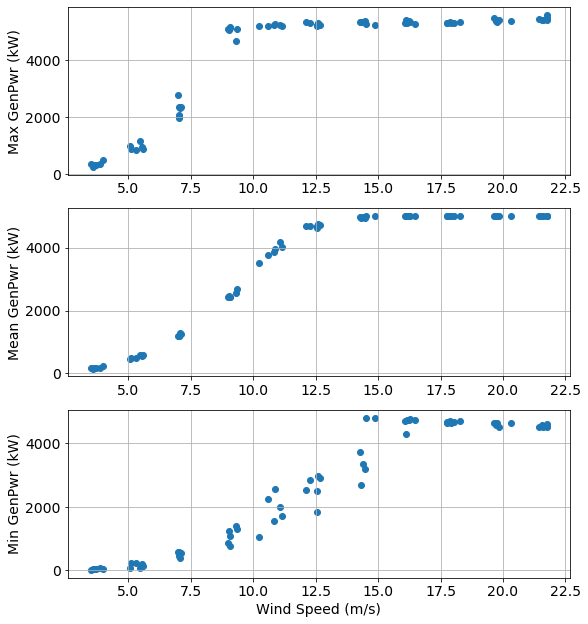

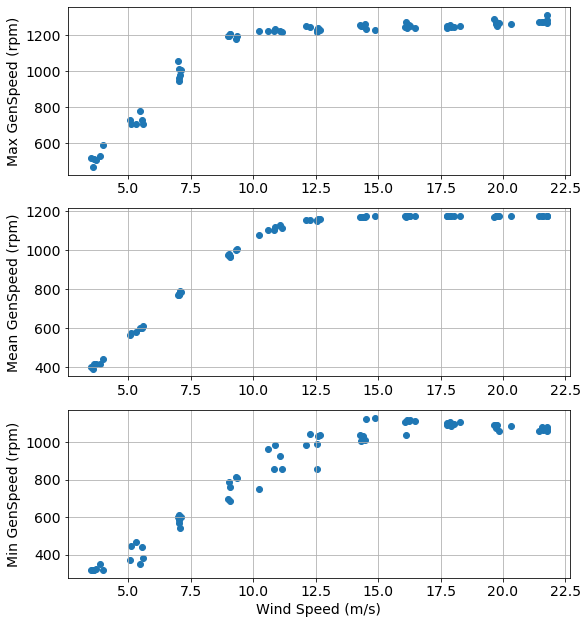

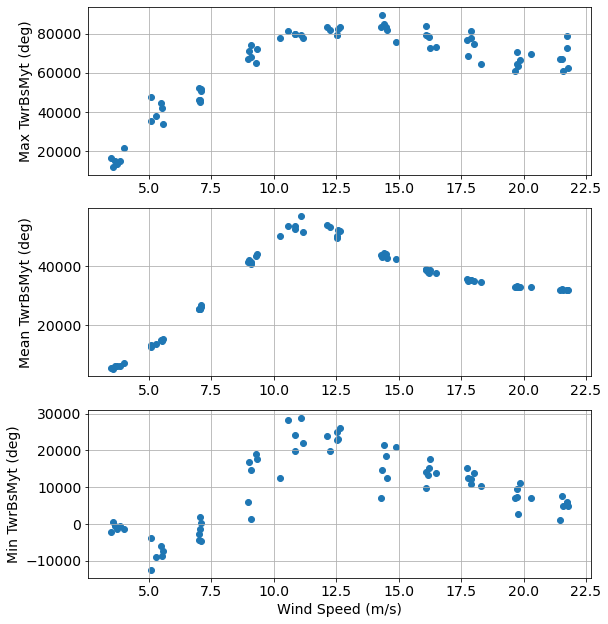

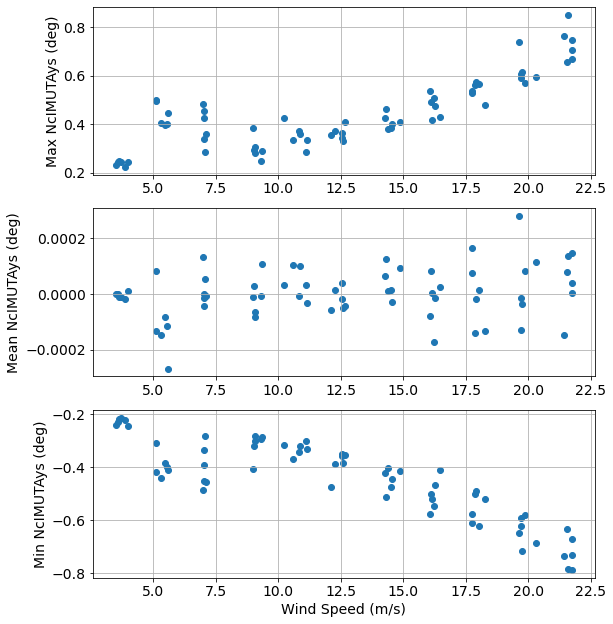

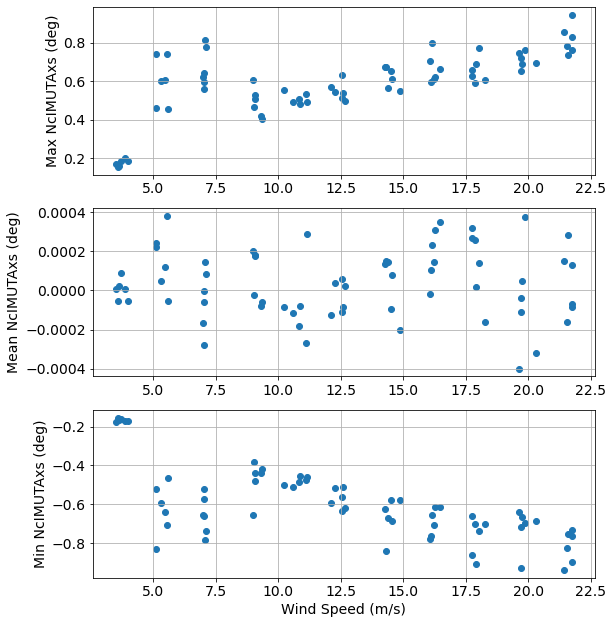

In [11]:
ss_channels = [
              [('GenPwr','max'),
               ('GenPwr','mean'),
               ('GenPwr','min')
              ],
              [
               ('GenSpeed','max'),
                  ('GenSpeed','mean'),
                  ('GenSpeed','min')
              ],
              [
               ('TwrBsMyt','max'),
                  ('TwrBsMyt','mean'),
                  ('TwrBsMyt','min')
              ],
#               [
#                ('PtfmYaw','max'),
#                   ('PtfmYaw','mean'),
#                   ('PtfmYaw','min')
#               ],
#               [
#                ('PtfmRoll','max'),
#                   ('PtfmRoll','mean'),
#                   ('PtfmRoll','min')
#               ],
              [
               ('NcIMUTAys','max'),
                  ('NcIMUTAys','mean'),
                  ('NcIMUTAys','min')
              ],
              [
               ('NcIMUTAxs','max'),
                  ('NcIMUTAxs','mean'),
                  ('NcIMUTAxs','min')
              ],
    
                
              
#                ('RotThrust','max'),
#                ('TwrBsMyt','std'),
#                ('TwrBsMxt','std'),
#                ('NcIMUTAxs','std') 
              ]

units = ['kW','rpm','deg','deg','deg','m/s^2','m/s^2','kNm']

plt.rcParams["figure.figsize"] = [9,3.5 * len(ss_channels[0])]
font = {'size'   : 14}

plt.rc('font', **font)
    
fig = [None] * len(ss_channels)
ax = [None] * len(ss_channels)

i = 0
for st_i, ws in zip(st,windspeeds):
    for iset, chan_set in enumerate(ss_channels):
        if not i:
            fig[iset], ax[iset] = plt.subplots(len(chan_set),1)
            
    
        for ichan, chan in enumerate(chan_set):     
            try:
                ax[iset][ichan].scatter(ws,st_i[chan[0],chan[1]])
            except:
                pass
            ax[iset][ichan].set_xlabel('Wind Speed (m/s)')
            ax[iset][ichan].set_ylabel(chan)
            ax[iset][ichan].grid(True)
            
            if ichan < len(chan_set)-1:
                ax[iset][ichan].set_xlabel('')
                 
            ax[iset][ichan].set_ylabel(chan[1].capitalize() + ' ' + chan[0] + ' (' + units[iset] + ')')
            
#         if chan[0] != 'PtfmYaw':
#             fig[iset].legend(('IEA-15MW Fixed Bottom','CT-15MW Semi (high bandwidth)'),loc=4,bbox_to_anchor=(0.65, .885))
            
        if False:  # Print!
            save_fig_dir = '/Users/dzalkind/Projects/CarbonTrust/Deliverables/CT-Semi_Draft'
            fig[iset].savefig(os.path.join(save_fig_dir,chan[0]))
            
    i+=1


#     legs = tuple([os.path.basename(test) for test in test_dir])
#     plt.legend(legs, loc='upper center', bbox_to_anchor=(
#                         0.5, 0.0), borderaxespad=2, ncol=2)

# Print Max Rot Thrust


# ws
plt.show()

# test_dir   = ['/Users/dzalkind/Tools/WEIS-3/results/UMaine-Fixed/DISCON_fixed_ps100/ntm',
#               '/Users/dzalkind/Tools/WEIS-3/results/UMaine-Fixed/DISCON_fixed_ps080/ntm',
#              '/Users/dzalkind/Tools/WEIS-3/results/UMaine-Fixed/DISCON_fixed_ps100_const_pwr/ntm']

- controller_0: original floating control (80% thrust limit)
- controller_1: constant power controller (80% thrust limit)
- controller_2: constant torque (100% thrust limit)
- controller_3: constant power (100% thrust limit)

# Review Load Ran

In [18]:
st[0].TwrBsMyt['min'].sort_values(ascending=False)


# %matplotlib inline

27    28930.504341
26    28197.881700
32    26186.969818
34    24996.232351
25    24063.137340
          ...     
7     -6002.466962
11    -7443.240597
9     -8689.927944
6     -8954.556467
8    -12611.482149
Name: min, Length: 66, dtype: float64

 # Plot Selected Cases

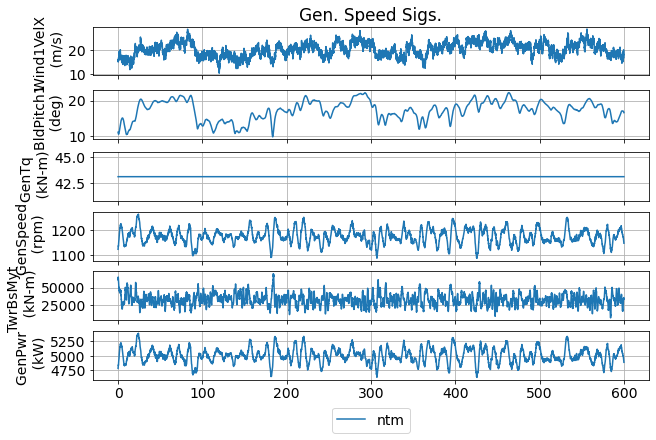

In [27]:
# Select Case I.D.s
case_ids = [58]


output_ext = '.outb'
plt.rcParams["figure.figsize"] = [9,6]

#  Define Plot cases 
cases = {}
cases['Gen. Speed Sigs.'] = ['Wind1VelX', 'BldPitch1', 'GenTq', 'GenSpeed','TwrBsMyt','GenPwr']#,'PtfmPitch','PtfmYaw']
# cases['Plt. Control Sigs.'] = ['RtVAvgxh', 'BldPitch1', 'Fl_Pitcom', 'FA_AccR','PtfmPitch','SS_dOmF','WE_Vw']
# cases['Platform Motion'] = ['PtfmSurge', 'PtfmSway', 'PtfmHeave', 'PtfmPitch','PtfmRoll','PtfmYaw']

case_outs = [[outs[case_id] for outs in outfiles] for case_id in case_ids]
case_outs

for i_case, case in enumerate(case_ids):
    fastout = fast_io.load_fast_out(case_outs[i_case], tmin=200)

    # Plot
    fig, ax = fast_pl.plot_fast_out(cases, fastout, showplot=False)

    legs = tuple([os.path.basename(test) for test in test_dir])
    plt.legend(legs, loc='upper center', bbox_to_anchor=(
                        0.5, 0.0), borderaxespad=2, ncol=2)
    
#     for a in ax:
#     plt.xlim([200,300])
    

In [ ]:
%matplotlib
case_outs

In [20]:
# test_dir = ['/Users/dzalkind/Tools/WEIS-3/results/CT-spar/DISCON_fixed_ps080_const_pwr/simp',
#            '/Users/dzalkind/Tools/WEIS-3/results/CT-spar/DISCON_fixed_ps100_const_pwr/simp',
#            '/Users/dzalkind/Tools/WEIS-3/results/CT-spar/DISCON_fixed_ps100/simp']

# fastout[0]

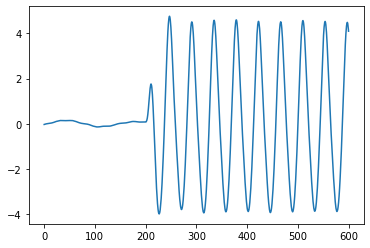

In [10]:
cont_out = '/Users/dzalkind/Tools/WEIS-3/results/CT-spar/DISCON_fixed_ps100_const_pwr/simp/step_0.RO.dbg'
rosco_out = fast_io.load_fast_out(cont_out, tmin=200)

rosco_out[0]

plt.plot(rosco_out[0]['Time'],180/3.14 * rosco_out[0]['Fl_Pitcom'])
plt.show()

# cases = {}
# cases['Floating Pitch Control'] = ['Fl_Pitcom']

# fig, ax = fast_pl.plot_fast_out(cases, rosco_out, showplot=False)

# Power Production
Min, Avg, and Max vs. Wind Speed

In [135]:
# unique_wind_speeds = np.unique(np.array(windspeeds)[indAEP])

# mean_gen_pwr = np.zeros(len(unique_wind_speeds))
# min_gen_pwr  = np.zeros(len(unique_wind_speeds))
# max_gen_pwr  = np.zeros(len(unique_wind_speeds))
# for i, ws in enumerate(unique_wind_speeds):
#     ws_ind = windspeeds == ws
#     mean_gen_pwr[i] = np.mean(st['GenPwr']['mean'][ws_ind])
#     min_gen_pwr[i]  = np.min(st['GenPwr']['min'][ws_ind])
#     max_gen_pwr[i]  = np.max(st['GenPwr']['max'][ws_ind])

# rated_power = fastRead.fst_vt['DISCON_in']['VS_RtPwr']

# # plot
# plt.figure(figsize=[8,6])
# plt.plot([3.,25.],rated_power*np.array([1.,1.])/1e3,linestyle='--',color='k',label='rated')
# plt.plot(unique_wind_speeds,mean_gen_pwr,linewidth=3,label='mean')
# plt.plot(unique_wind_speeds,min_gen_pwr,linewidth=1.5,color='r',label='min/max')
# plt.plot(unique_wind_speeds,max_gen_pwr,linewidth=1.5,color='r')

# plt.legend(fontsize=12,loc='lower right')
# plt.ylabel('Gen. Power (kW)',fontsize=14)
# plt.xlabel('Wind Speed (m/s)',fontsize=14)
# plt.show()

KeyError: 'GenPwr'

# Generator Speed
- List top k generator speed transients

In [16]:
k = 3
j = 2


cm_wind_speed = cm_wind[('InflowWind','WindSpeed')]
cm_dlc = cm_wind[('IEC','DLC')]
st_gen = st['GenSpeed']['max']

# cm_wind

max_df = pd.DataFrame(cm_dlc)
max_df[('WindSpeed','m/s')] = cm_wind_speed
max_df[('MaxGenSpeed','rpm')] = st_gen
max_df[('Max_TwrBsMyt','kNm')] = st['TwrBsMyt']['max']
max_df[('Max_RootMyb1','kNm')] = st['RootMyb1']['max']
max_df[('Max_RootMyb2','kNm')] = st['RootMyb2']['max']
max_df[('Max_RootMyb3','kNm')] = st['RootMyb3']['max']

max_gen_df = max_df.sort_values(('MaxGenSpeed','rpm'),ascending=False).head(k)
# max_gen_df[[('IEC','DLC'),('WindSpeed','m/s')]]

- Plot top j timeseries

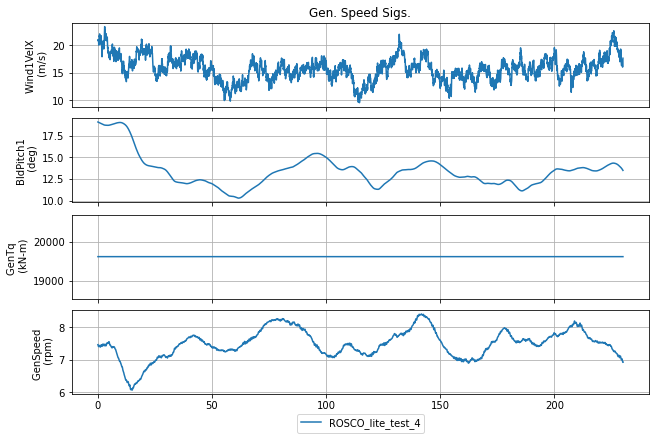

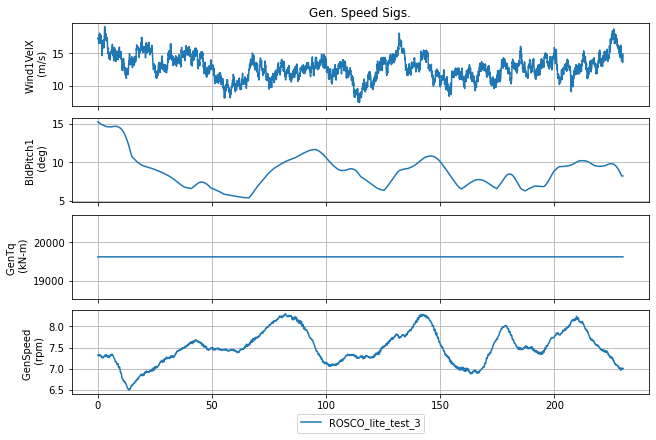

In [17]:
output_ext = '.outb'
plt.rcParams["figure.figsize"] = [9,6]

#  Define Plot cases 
#  --- Comment,uncomment, create, and change these as desired...
cases = {}
cases['Gen. Speed Sigs.'] = ['Wind1VelX', 'BldPitch1', 'GenTq', 'GenSpeed']

outfiles = list(test_dir + os.path.sep + max_gen_df.index + output_ext)

for of in outfiles[0:j]:
    # Load output info and data
    fastout = fast_io.load_fast_out(of, tmin=100)
    
    # Plot
    fig = fast_pl.plot_fast_out(cases, fastout, showplot=False)
    

# Tower Loads
- List top k loads
- Plot top j cases

In [18]:
k = 3
j = 2


st_twr = st['TwrBsMyt']['max']

max_twr_df = pd.DataFrame(cm_dlc)
max_twr_df[('WindSpeed','m/s')] = cm_wind_speed
max_twr_df[('Max_TwrBsMyt','kNm')] = st_twr

max_twr_df = max_twr_df.sort_values(('Max_TwrBsMyt','kNm'),ascending=False).head(k)
max_twr_df

,IEC,WindSpeed,Max_TwrBsMyt
,DLC,m/s,kNm
Case_Name,,,
ROSCO_lite_test_3,1.1,14.0,380374.211137
ROSCO_lite_test_2,1.1,11.0,344697.799781
ROSCO_lite_test_4,1.1,17.0,311955.056061


- Plot top j timeseries

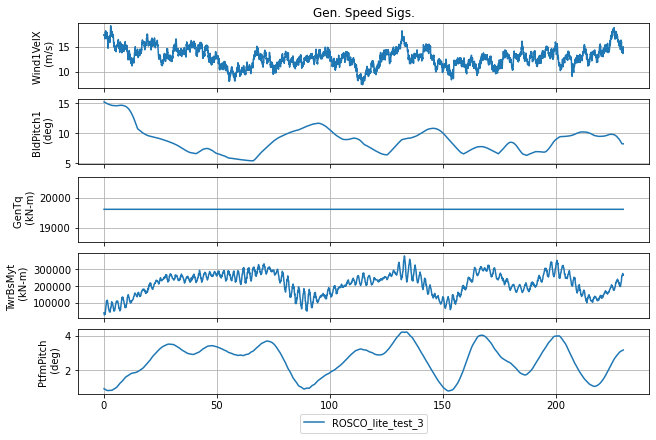

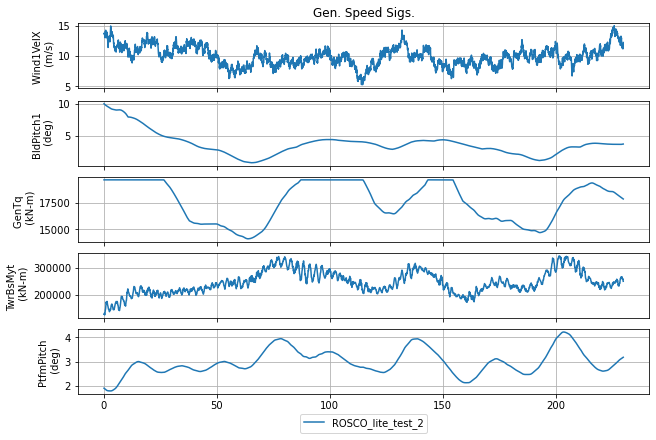

In [19]:
output_ext = '.outb'
plt.rcParams["figure.figsize"] = [9,6]

#  Define Plot cases 
#  --- Comment,uncomment, create, and change these as desired...
cases = {}
cases['Gen. Speed Sigs.'] = ['Wind1VelX', 'BldPitch1', 'GenTq', 'TwrBsMyt','PtfmPitch']

outfiles = list(test_dir + os.path.sep + max_twr_df.index + output_ext)

for of in outfiles[0:j]:
    # Load output info and data
    fastout = fast_io.load_fast_out(of, tmin=100)
    
    # Plot
    fig = fast_pl.plot_fast_out(cases, fastout, showplot=False)
    

In [83]:
# # Compare to results in compRunDir
# # Check these maxima
# caseMeasures    = ['RotSpeed',
#                     'RootMyb',
#                     'TwrBsMyt',
#                     'PtfmPitch']

# loadRanksThis   = Processing.load_yaml(os.path.join(fp.results_dir,'dataset1_LoadRanking.yaml'))

# # If no comparison exists, just print own stats
# try:
#     loadRanksComp   = Processing.load_yaml(os.path.join(compRunDir,turbine,'stats','dataset1_LoadRanking.yaml'))

#     print('\t\t{}'.format(turbine))
#     print('----------------------------------------')
#     print('\t\t{}\t{}'.format('This Control','Baseline'))
#     for meas in caseMeasures:
#         try:
#             print('Max {} \t{:1.3e}\t{:1.3e}'.format(meas,loadRanksThis[meas]['max'][0],loadRanksComp[meas]['max'][0]))
#         except:
#             print('{} is not in stats'.format(meas))

# except:
#     print('No comparison files exist!')

#     print('\t\t{}'.format(turbine))
#     print('----------------------------------------')
#     print('\t\t{}\t{}'.format('This Control','Baseline'))
#     for meas in caseMeasures:
#         try:
#             print('Max {} \t{:1.3e}'.format(meas,loadRanksThis[meas]['max'][0]))
#         except:
#             print('{} is not in stats'.format(meas))
# windspeeds, seed, IECtype, cm_wind = Processing.get_windspeeds(cm, return_df=True)

# stats = FileTools.load_yaml(os.path.join(fp.results_dir,'dataset1_stats.yaml'))
# st = pdTools.dict2df(stats)

# pp = Analysis.Power_Production()
# Vavg = 10   # Average wind speed of cite
# Vrange = [2,26] # Range of wind speeds being considered
# indAEP = np.array(IECtype) == 'NTM'

# pp.windspeeds = np.sort(np.array(windspeeds)[indAEP])
# AEP = pp.AEP(st[indAEP],pp.windspeeds)
# RatedPower = fastRead.fst_vt['DISCON_in']['VS_RtPwr']
# print('Cap. Factor = {:3.3f}'.format(AEP/8760/RatedPower*1000))

# # Compare to results in compRunDir
# # Check these maxima
# caseMeasures    = ['RotSpeed',
#                     'RootMyb',
#                     'TwrBsMyt',
#                     'PtfmPitch']

# loadRanksThis   = Processing.load_yaml(os.path.join(fp.results_dir,'dataset1_LoadRanking.yaml'))

# # If no comparison exists, just print own stats
# try:
#     loadRanksComp   = Processing.load_yaml(os.path.join(compRunDir,turbine,'stats','dataset1_LoadRanking.yaml'))

#     print('\t\t{}'.format(turbine))
#     print('----------------------------------------')
#     print('\t\t{}\t{}'.format('This Control','Baseline'))
#     for meas in caseMeasures:
#         try:
#             print('Max {} \t{:1.3e}\t{:1.3e}'.format(meas,loadRanksThis[meas]['max'][0],loadRanksComp[meas]['max'][0]))
#         except:
#             print('{} is not in stats'.format(meas))

# except:
#     print('No comparison files exist!')

#     print('\t\t{}'.format(turbine))
#     print('----------------------------------------')
#     print('\t\t{}\t{}'.format('This Control','Baseline'))
#     for meas in caseMeasures:
#         try:
#             print('Max {} \t{:1.3e}'.format(meas,loadRanksThis[meas]['max'][0]))
#         except:
#             print('{} is not in stats'.format(meas))